In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import pylab
import warnings
warnings.filterwarnings("ignore")
from google.colab import files
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout
from tensorflow.keras.models import Model

In [13]:
uploaded = files.upload()

Saving Index2018.csv to Index2018.csv


In [14]:
df = pd.read_csv('Index2018.csv')
print(df)

            date          spx       dax         ftse    nikkei
0     07/01/1994   469.900000   2224.95  3445.980000  18124.01
1     10/01/1994   475.270000   2225.00  3440.580000  18443.44
2     11/01/1994   474.130000   2228.10  3413.770000  18485.25
3     12/01/1994   474.170000   2182.06  3372.020000  18793.88
4     13/01/1994   472.470000   2142.37  3360.010000  18577.26
...          ...          ...       ...          ...       ...
6264  23/01/2018  2839.130362  13559.60  7731.827774  24124.15
6265  24/01/2018  2837.544008  13414.74  7643.428966  23940.78
6266  25/01/2018  2839.253031  13298.36  7615.839954  23669.49
6267  26/01/2018  2872.867839  13340.17  7665.541292  23631.88
6268  29/01/2018  2853.528411  13324.48  7671.533300  23629.34

[6269 rows x 5 columns]


In [15]:
df.describe()

,spx,dax,ftse,nikkei
count,6269.000000,6269.000000,6269.000000,6269.000000
mean,1288.127542,6080.063363,5422.713545,14597.055700
std,487.586473,2754.361032,1145.572428,4043.122953
min,438.920000,1911.700000,2876.600000,7054.980000
25%,990.671905,4069.350000,4486.100000,10709.290000
50%,1233.420000,5773.340000,5662.430000,15028.170000
75%,1459.987747,7443.070000,6304.250000,17860.470000
max,2872.867839,13559.600000,7778.637689,24124.150000


In [16]:
df['date'].dtype

dtype('O')

In [17]:
df['date'] = pd.to_datetime(df['date'],dayfirst=True)

In [18]:
# Date column is now changed to datetime data type instead of string
df['date'].dtype

dtype('<M8[ns]')

In [19]:
# Date needs to be sorted so it is in chronological order
df.sort_values(by='date')

,date,spx,dax,ftse,nikkei
0,1994-01-07,469.900000,2224.95,3445.980000,18124.01
1,1994-01-10,475.270000,2225.00,3440.580000,18443.44
2,1994-01-11,474.130000,2228.10,3413.770000,18485.25
3,1994-01-12,474.170000,2182.06,3372.020000,18793.88
4,1994-01-13,472.470000,2142.37,3360.010000,18577.26
...,...,...,...,...,...
6264,2018-01-23,2839.130362,13559.60,7731.827774,24124.15
6265,2018-01-24,2837.544008,13414.74,7643.428966,23940.78
6266,2018-01-25,2839.253031,13298.36,7615.839954,23669.49
6267,2018-01-26,2872.867839,13340.17,7665.541292,23631.88


In [20]:
df = df.set_index('date')

In [21]:
# I am setting the frequency to 'business day' because there is no stock exchange on weekends
df = df.asfreq('b')

In [22]:
# there can not be any missing data in a time series analysis
print(df.isna().sum())

spx       8
dax       8
ftse      8
nikkei    8
dtype: int64


In [23]:
# Addressing missing values using 'Interpolation"
df=df.interpolate(method ='linear', limit_direction ='forward')
df.isna().sum()

,0
spx,0
dax,0
ftse,0
nikkei,0


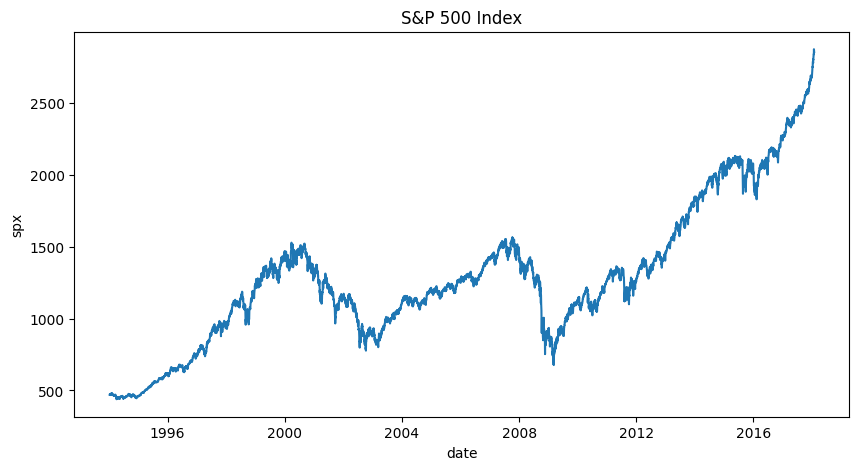

In [24]:
# visualization

plt.figure(figsize=(10,5))
sns.lineplot(data=df,x='date',y='spx').set_title('S&P 500 Index');

In [29]:
sts.adfuller(df['spx'])

(np.float64(1.118732104680224),
 np.float64(0.9953733649781237),
 10,
 6266,
 {'1%': np.float64(-3.4313940441948807),
  '5%': np.float64(-2.8620013751563964),
  '10%': np.float64(-2.567015587023998)},
 np.float64(50243.88599230713))

Dickey Fuller test to test for stationarity. Since the t-stat of 1.12 is larger than the critical values the conclusion is to fail to reject the null. Which means that the time series is non-stationary. For the deep learning models, that is not a problem, but I am also planning on using ARIMA to compare with.

In [30]:
df['spx_diff'] = df['spx'].diff()

In [31]:
sts.adfuller(df['spx_diff'].dropna())

(np.float64(-26.24911657343484),
 0.0,
 9,
 6266,
 {'1%': np.float64(-3.4313940441948807),
  '5%': np.float64(-2.8620013751563964),
  '10%': np.float64(-2.567015587023998)},
 np.float64(50236.02163974113))

Applying first differencing to the data results in stationarity, indicating that the original series has a strong autocorrelation at lag 1. This autocorrelation contributes significantly to the series' predictability. By differencing, we effectively remove the underlying trend, allowing the model to focus on the stationary components of the data.

Text(0, 0.5, 'S&P Index Difference')

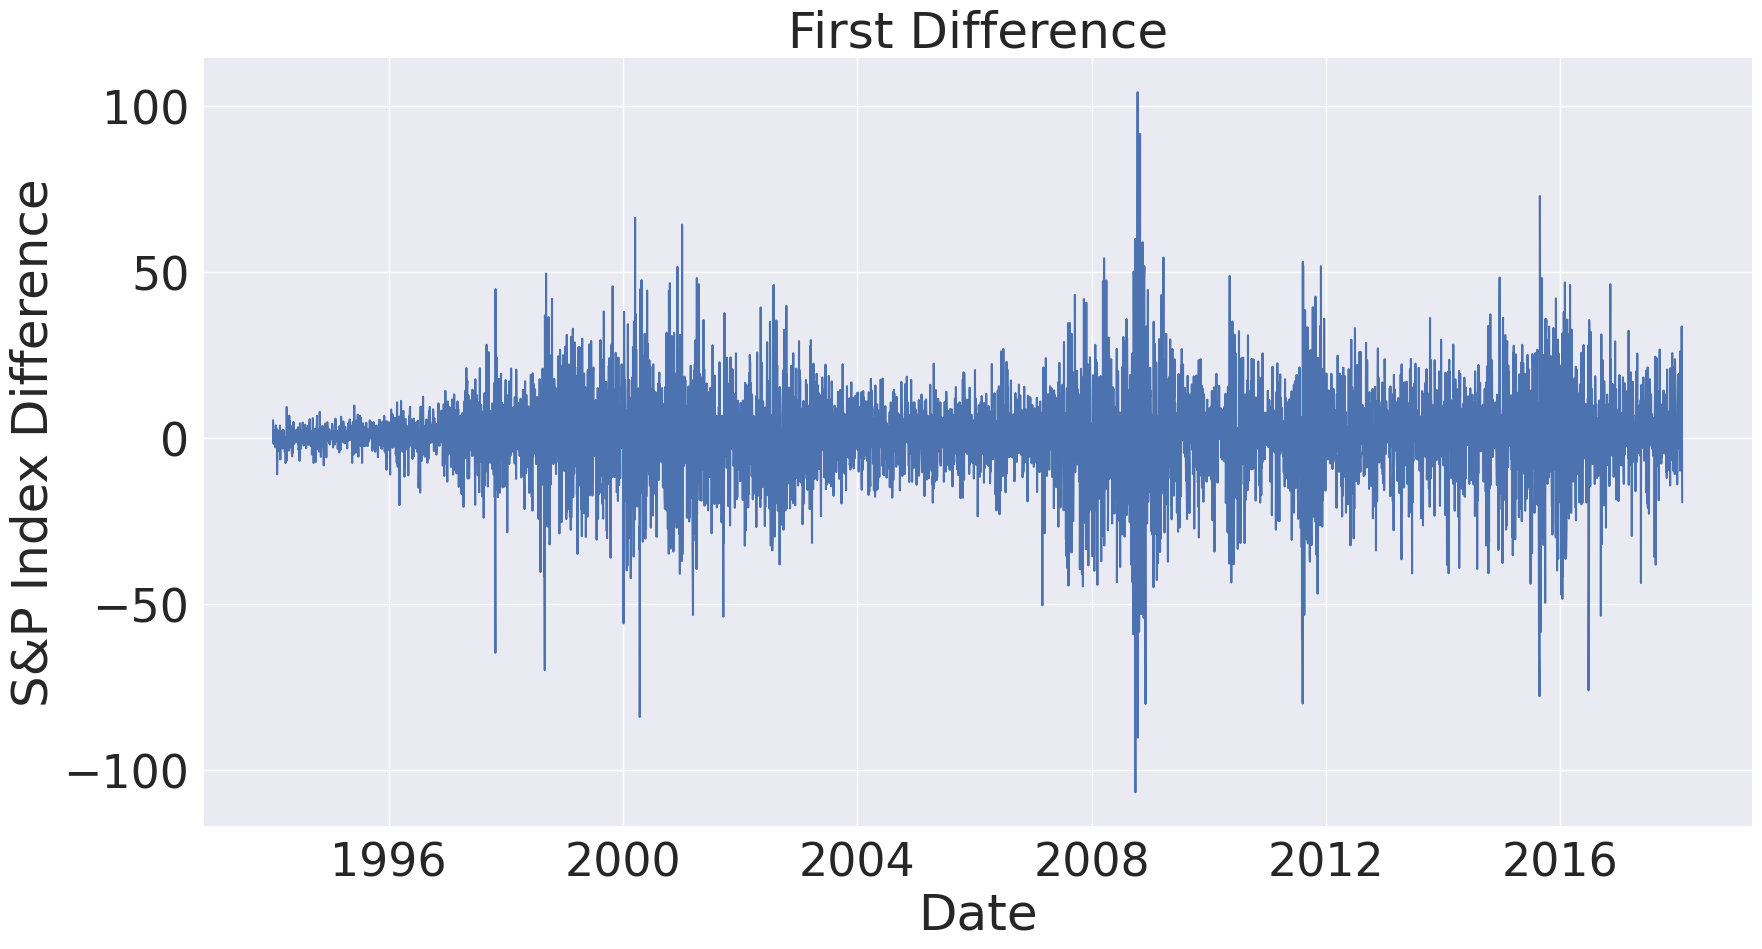

In [32]:
plt.figure(figsize=(20,10))
sns.set(font_scale=3)
sns.lineplot(data=df,x='date',y='spx_diff').set_title('First Difference');
plt.xlabel("Date")
plt.ylabel("S&P Index Difference")

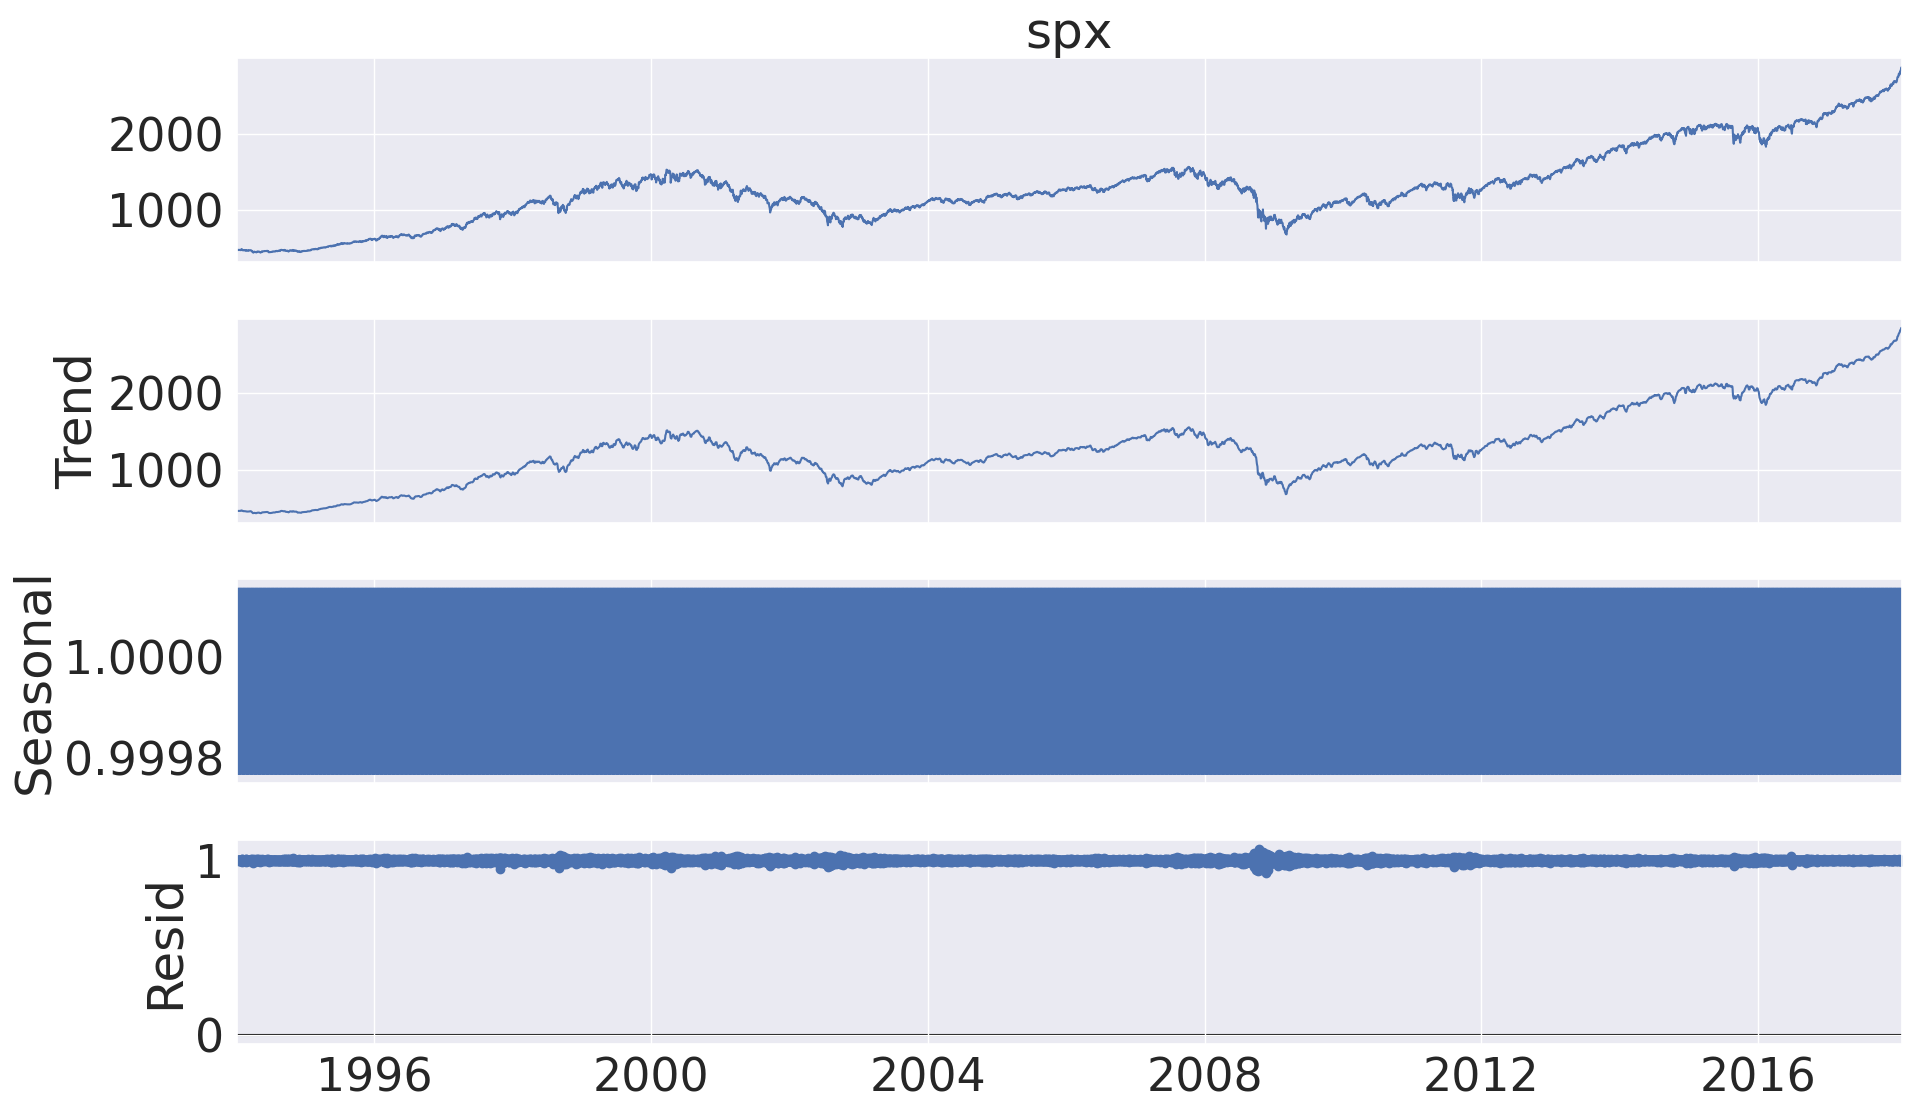

In [34]:
decomp = seasonal_decompose(df['spx'], model = "multiplicative")
from pylab import rcParams
rcParams['figure.figsize'] = 20,12
decomp.plot()
plt.show()

The first plot shows the variable itself. The second plot shows the trend. The third shows the seasonality. The fourth shows the residual.

We find that the data is almost entirely composed of the trend. Seasonality is so sporadic that it appears just as a solid rectangle. This implies that there is no seasonal pattern.

This is useful for determining which model could have the best performance. The decomposition reveals a dominant trend component and no significant seasonality. This favors models that do not rely on seasonal cycles for prediction. Deep learning models such as LSTM, GRU, and Transformers are well-suited for such data, as they do not require explicit seasonal patterns and can effectively learn from trend-dominated sequences.

In [35]:
# Define the size of the training data
size = int(len(df)*0.9)
# Create training data and test data
df_train = df.iloc[:size]
df_test = df.iloc[size:]

In [120]:
history = list(df_train['spx'])
predictions = []

for t in range(len(df_test)):
    model = ARIMA(history, order=(1, 1, 1))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(df_test['spx'].iloc[t])

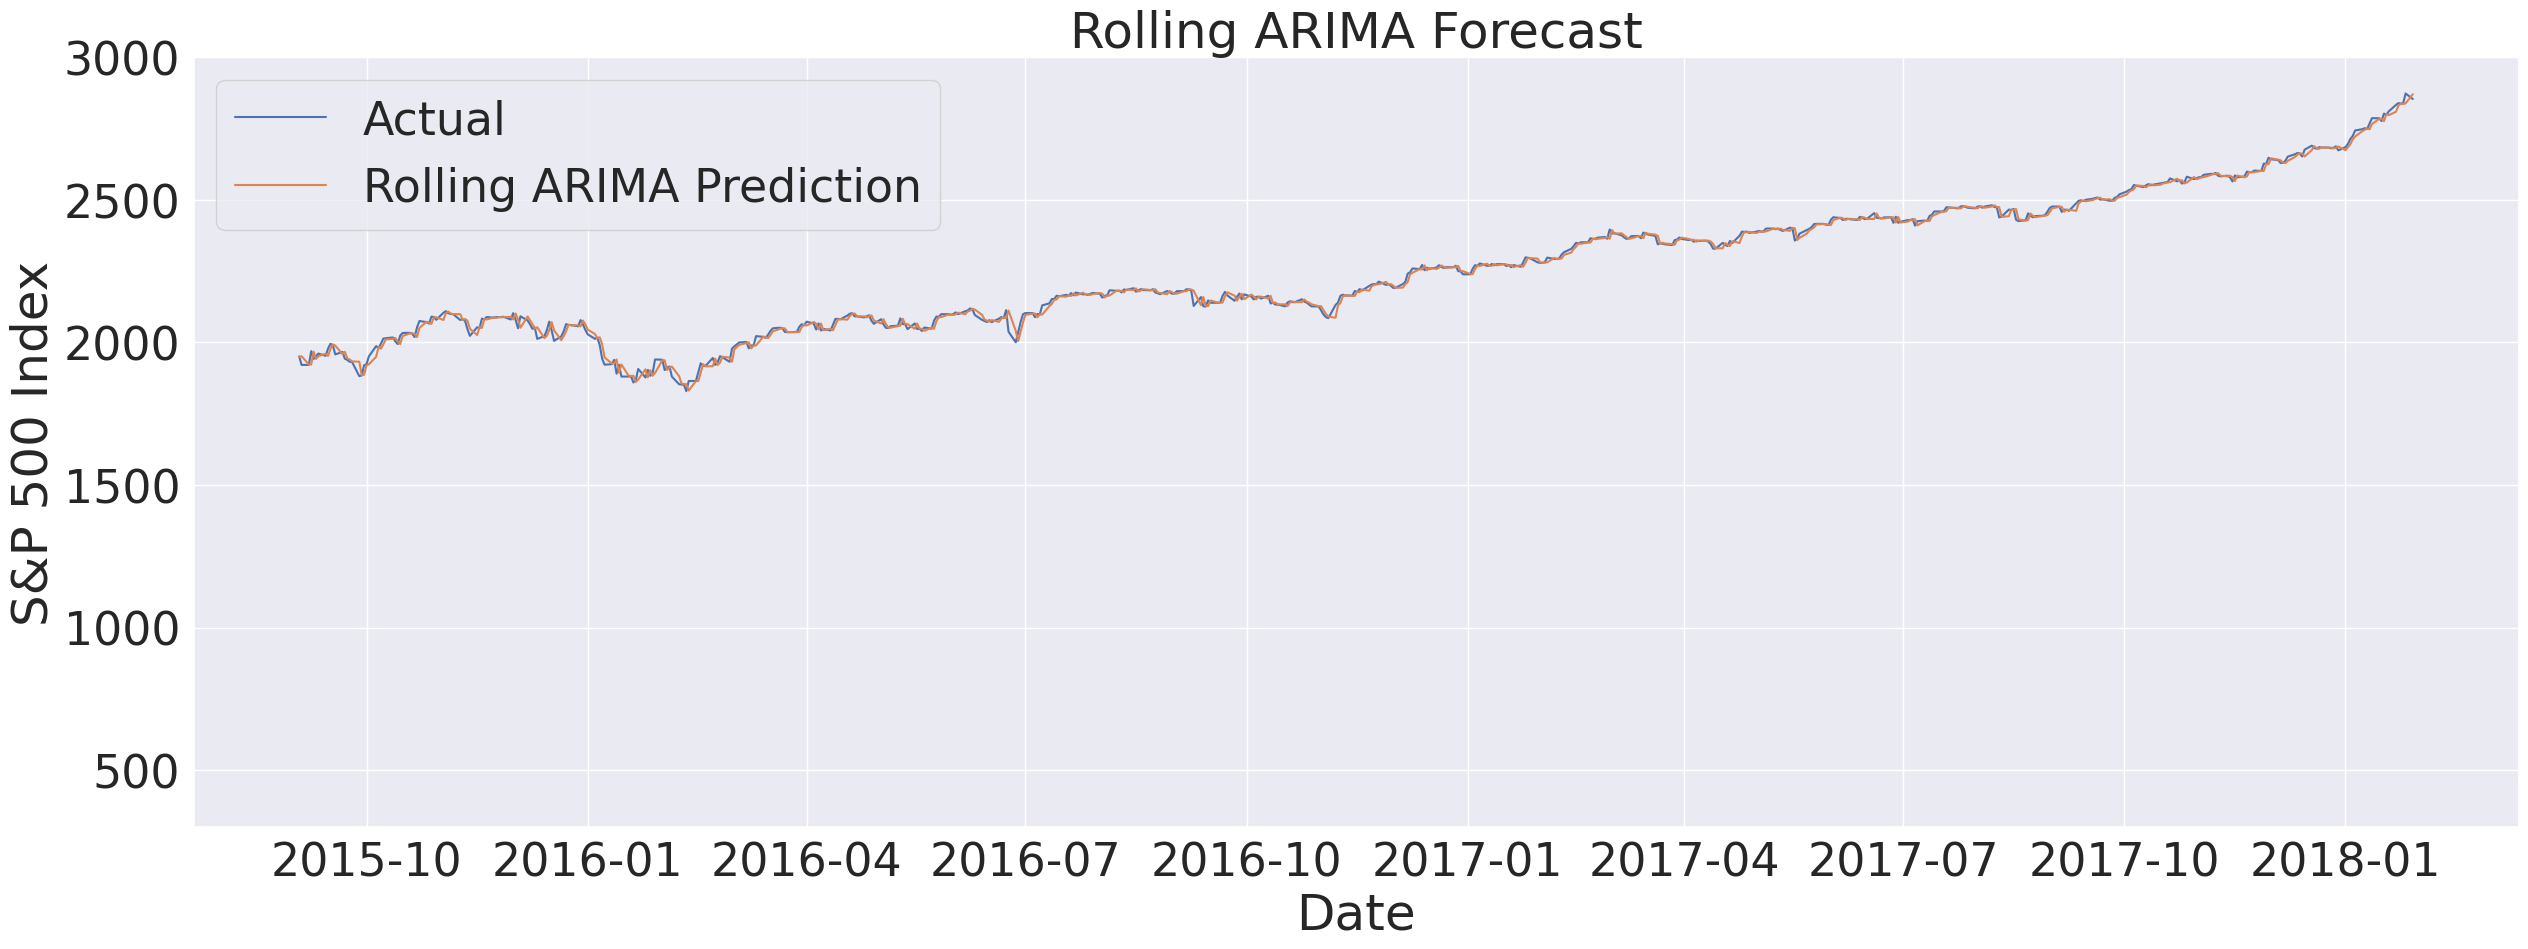

In [127]:
plot_arima = pd.DataFrame({
    'date': df_test.index[-len(y_pred_arima):],
    'Actual': y_true_arima.flatten(),
    'ARIMA_Rolling': y_pred_arima.flatten()
})

plt.figure(figsize=(30, 10))
plt.ylim(300, 3000)
sns.lineplot(data=plot_arima, x='date', y='Actual', label='Actual')
sns.lineplot(data=plot_arima, x='date', y='ARIMA_Rolling', label='Rolling ARIMA Prediction')
plt.xlabel("Date")
plt.ylabel("S&P 500 Index")
plt.title("Rolling ARIMA Forecast")
plt.legend()
plt.grid(True)
plt.show()


In [121]:
# Convert predictions to array and align shapes
y_pred_arima = np.array(predictions).reshape(-1, 1)
y_true_arima = df_test['spx'].values.reshape(-1, 1)

rmse_arima_rolling = mean_squared_error(y_true_arima, y_pred_arima)
print(f"ARIMA RMSE: {rmse_arima_rolling:.4f}")

ARIMA RMSE: 215.4741


In [28]:
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df[['spx']])

df_scaled = pd.DataFrame(scaled_values, columns=['spx'], index=df.index)

In [131]:
WINDOW_SIZE = 30

df_train_scaled = df_scaled.loc[df_train.index]
df_test_scaled = df_scaled.loc[df_test.index]

# Convert to array
train_vals = df_train_scaled['spx'].values
test_vals = df_test_scaled['spx'].values

In [132]:
# Define LSTM model
lstm_model = Sequential([
    LSTM(64, input_shape=(WINDOW_SIZE, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

In [133]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_vals, WINDOW_SIZE)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Train
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0104
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.0904e-04
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.0300e-04
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.0529e-04
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 9.4300e-05
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 9.4138e-05
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 9.4092e-05
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 8.3561e-05
Epoch 9/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 8.4899e-05
Epoch 10/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 7.9924e-05


Creating sequences (windowing) is crucial because deep learning models like LSTM and GRU require fixed-length input sequences to learn temporal patterns. By turning the time series into overlapping windows of past values (X) and corresponding next values (y), we enable the model to predict future trends based on historical context. This setup transforms the time series into a supervised learning problem.

In [134]:
rolling_window = list(train_vals[-WINDOW_SIZE:])
lstm_preds = []

for t in range(len(test_vals)):
    X_input = np.array(rolling_window[-WINDOW_SIZE:]).reshape(1, WINDOW_SIZE, 1)
    pred = lstm_model.predict(X_input, verbose=0)[0][0]
    lstm_preds.append(pred)
    rolling_window.append(test_vals[t])

In [135]:
lstm_preds_inverted = scaler.inverse_transform(np.array(lstm_preds).reshape(-1, 1))
y_true_lstm = scaler.inverse_transform(test_vals.reshape(-1, 1))

# Create DataFrame for plotting
plot_lstm = pd.DataFrame({
    'date': df_test.index,
    'Actual': y_true_lstm.flatten(),
    'LSTM_Rolling': lstm_preds_inverted.flatten()
})

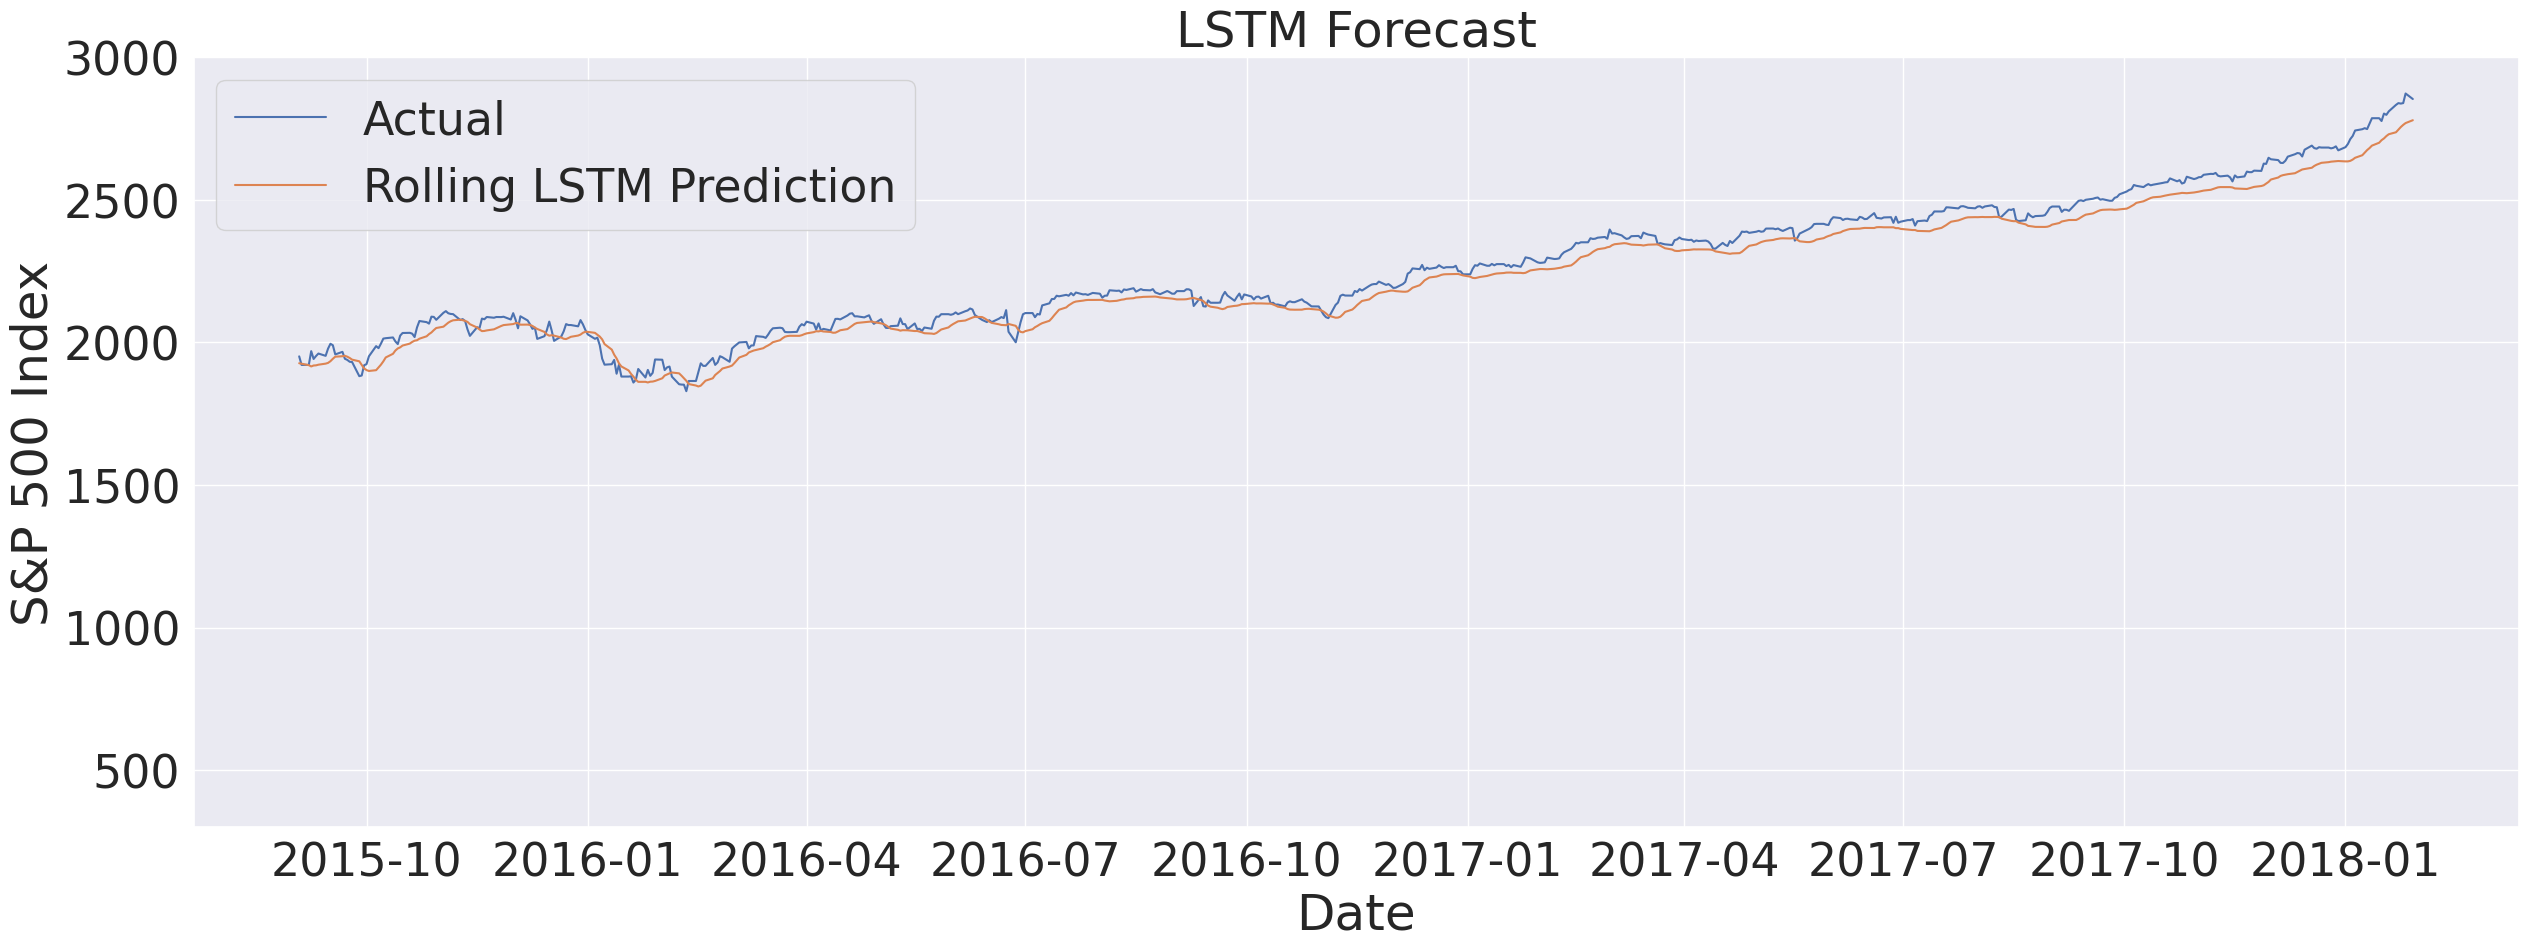

In [154]:
plt.figure(figsize=(30,10))
plt.ylim(300, 3000)
sns.lineplot(data=plot_lstm, x='date', y='Actual', label='Actual')
sns.lineplot(data=plot_lstm, x='date', y='LSTM_Rolling', label='Rolling LSTM Prediction')
plt.xlabel("Date")
plt.ylabel("S&P 500 Index")
plt.title("LSTM Forecast")
plt.legend()
plt.grid(True)
plt.show()

In [155]:
rmse_lstm_rolling = mean_squared_error(
    plot_lstm['Actual'], plot_lstm['LSTM_Rolling']
)
print(f"LSTM RMSE: {rmse_lstm_rolling:.4f}")



LSTM RMSE: 1719.8339


In [140]:
gru_model = Sequential([
    GRU(64, input_shape=(WINDOW_SIZE, 1)),
    Dense(1)
])

gru_model.compile(optimizer='adam', loss='mse')

X_train, y_train = create_sequences(train_vals, WINDOW_SIZE)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Train
gru_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0108
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 6.0853e-05
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 5.6374e-05
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 5.2692e-05
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 4.9530e-05
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 4.6916e-05
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 4.3187e-05
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 4.4427e-05
Epoch 9/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 3.9772e-05
Epoch 10/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 3.9684e-05


In [141]:
rolling_window = list(train_vals[-WINDOW_SIZE:])
gru_preds = []

for t in range(len(test_vals)):
    X_input = np.array(rolling_window[-WINDOW_SIZE:]).reshape(1, WINDOW_SIZE, 1)
    pred = gru_model.predict(X_input, verbose=0)[0][0]
    gru_preds.append(pred)
    rolling_window.append(test_vals[t])

In [142]:
gru_preds_inverted = scaler.inverse_transform(np.array(gru_preds).reshape(-1, 1))
y_true_gru = scaler.inverse_transform(test_vals.reshape(-1, 1))

# Create DataFrame
plot_gru = pd.DataFrame({
    'date': df_test.index,
    'Actual': y_true_gru.flatten(),
    'GRU_Rolling': gru_preds_inverted.flatten()
})

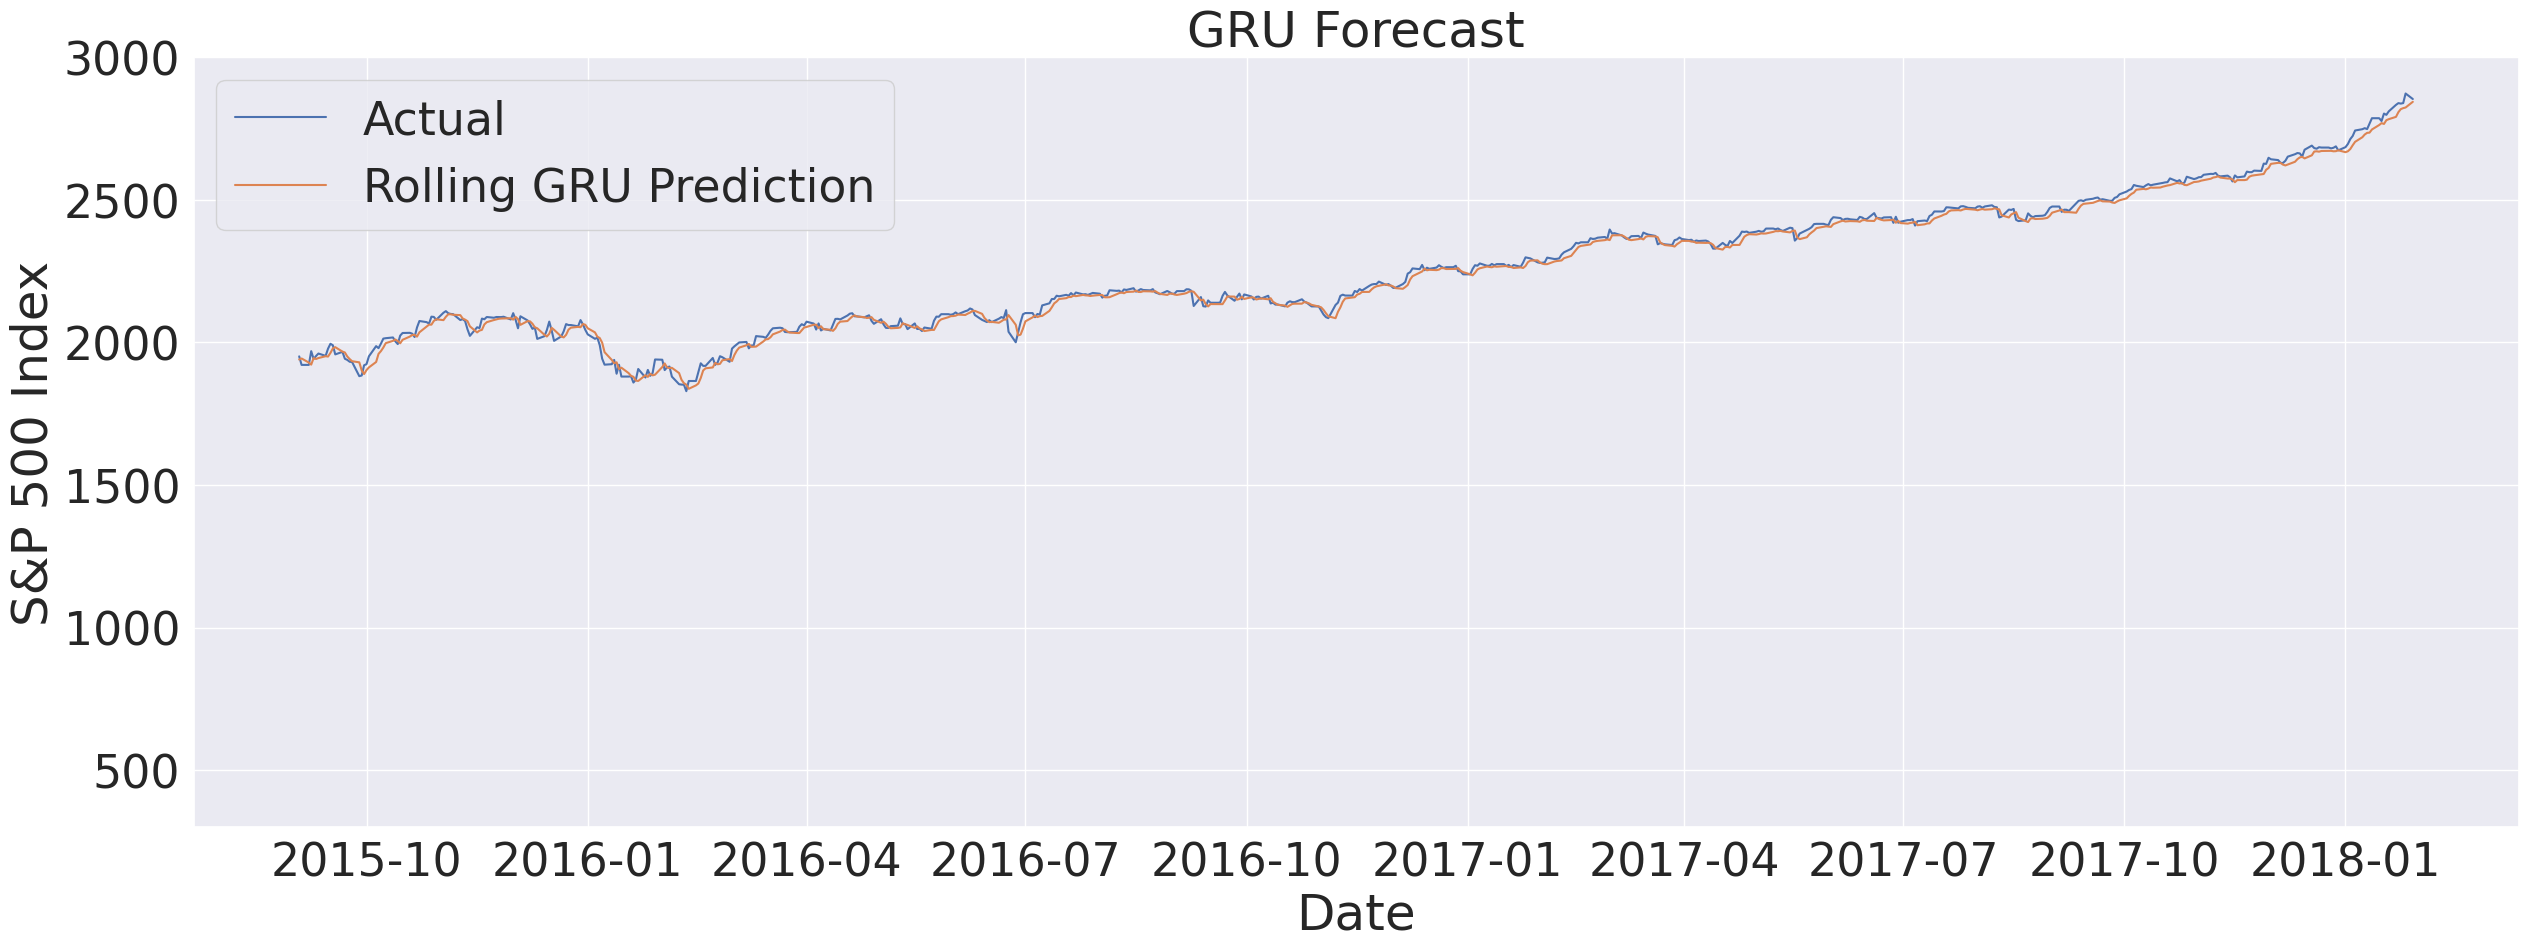

In [156]:
plt.figure(figsize=(30,10))
plt.ylim(300, 3000)
sns.lineplot(data=plot_gru, x='date', y='Actual', label='Actual')
sns.lineplot(data=plot_gru, x='date', y='GRU_Rolling', label='Rolling GRU Prediction')
plt.xlabel("Date")
plt.ylabel("S&P 500 Index")
plt.title("GRU Forecast")
plt.legend()
plt.grid(True)
plt.show()

In [157]:
rmse_gru_rolling = mean_squared_error(
    plot_gru['Actual'], plot_gru['GRU_Rolling']
)
print(f"GRU RMSE: {rmse_gru_rolling:.4f}")

GRU RMSE: 332.8170


In [147]:
def build_transformer(window_size, d_model=64, num_heads=4, ff_dim=128, dropout_rate=0.1):
    inputs = Input(shape=(window_size, 1))

    # Linear projection of input to d_model dimensions
    x = Dense(d_model)(inputs)

    # Self-attention block
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    x = LayerNormalization(epsilon=1e-6)(x + attn_output)

    # Feedforward block
    ff_output = Dense(ff_dim, activation='relu')(x)
    ff_output = Dense(d_model)(ff_output)
    x = LayerNormalization(epsilon=1e-6)(x + ff_output)

    # Final output: predict next value
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model


In [148]:
# Use same training data as LSTM/GRU
X_train, y_train = create_sequences(train_vals, WINDOW_SIZE)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Build model
transformer_model = build_transformer(WINDOW_SIZE)

# Train
transformer_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)


Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 0.4130
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0011
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 4.4949e-04
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 3.3312e-04
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 3.7853e-04
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 3.0858e-04
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 3.0292e-04
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 3.4354e-04
Epoch 9/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 3.8708e-04
Epoch 10/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 3.7495e-04


In [149]:
rolling_window = list(train_vals[-WINDOW_SIZE:])
transformer_preds = []

for t in range(len(test_vals)):
    X_input = np.array(rolling_window[-WINDOW_SIZE:]).reshape(1, WINDOW_SIZE, 1)
    pred = transformer_model.predict(X_input, verbose=0)[0][0]
    transformer_preds.append(pred)
    rolling_window.append(test_vals[t])

In [150]:
transformer_preds_inv = scaler.inverse_transform(np.array(transformer_preds).reshape(-1, 1))
y_true_trans = scaler.inverse_transform(test_vals.reshape(-1, 1))

plot_trans = pd.DataFrame({
    'date': df_test.index,
    'Actual': y_true_trans.flatten(),
    'Transformer_Rolling': transformer_preds_inv.flatten()
})

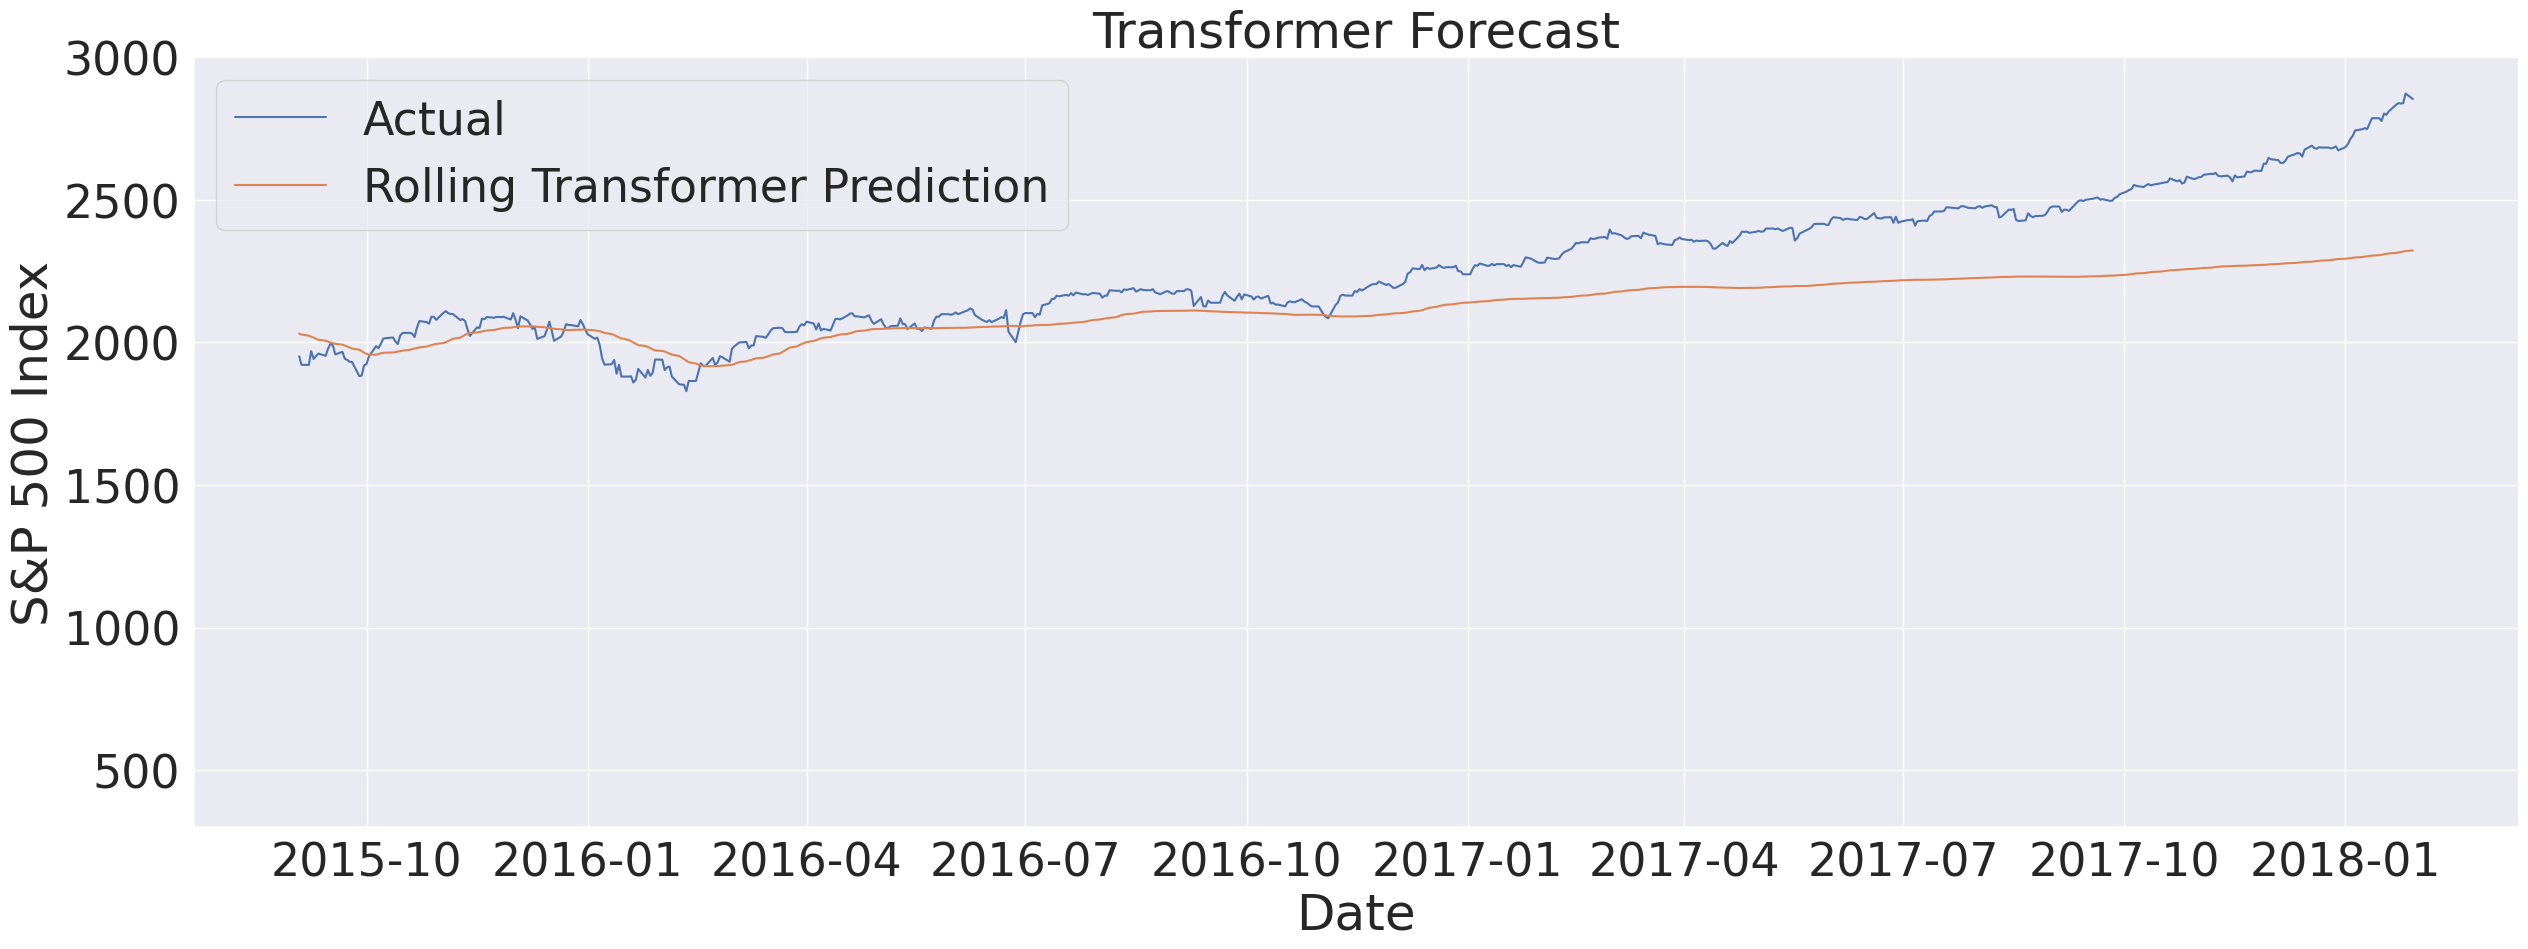

In [158]:
plt.figure(figsize=(30,10))
plt.ylim(300, 3000)
sns.lineplot(data=plot_trans, x='date', y='Actual', label='Actual')
sns.lineplot(data=plot_trans, x='date', y='Transformer_Rolling', label='Rolling Transformer Prediction')
plt.xlabel("Date")
plt.ylabel("S&P 500 Index")
plt.title("Transformer Forecast")
plt.legend()
plt.grid(True)
plt.show()

In [159]:
rmse_trans = mean_squared_error(
    plot_trans['Actual'], plot_trans['Transformer_Rolling']
)
print(f"Transformer RMSE: {rmse_trans:.4f}")

Transformer RMSE: 34895.0196


In [160]:
combined_plot = plot_arima[['date', 'Actual', 'ARIMA_Rolling']].copy()
combined_plot['LSTM_Rolling'] = plot_lstm['LSTM_Rolling'].values
combined_plot['GRU_Rolling'] = plot_gru['GRU_Rolling'].values
combined_plot['Transformer_Rolling'] = plot_trans['Transformer_Rolling'].values

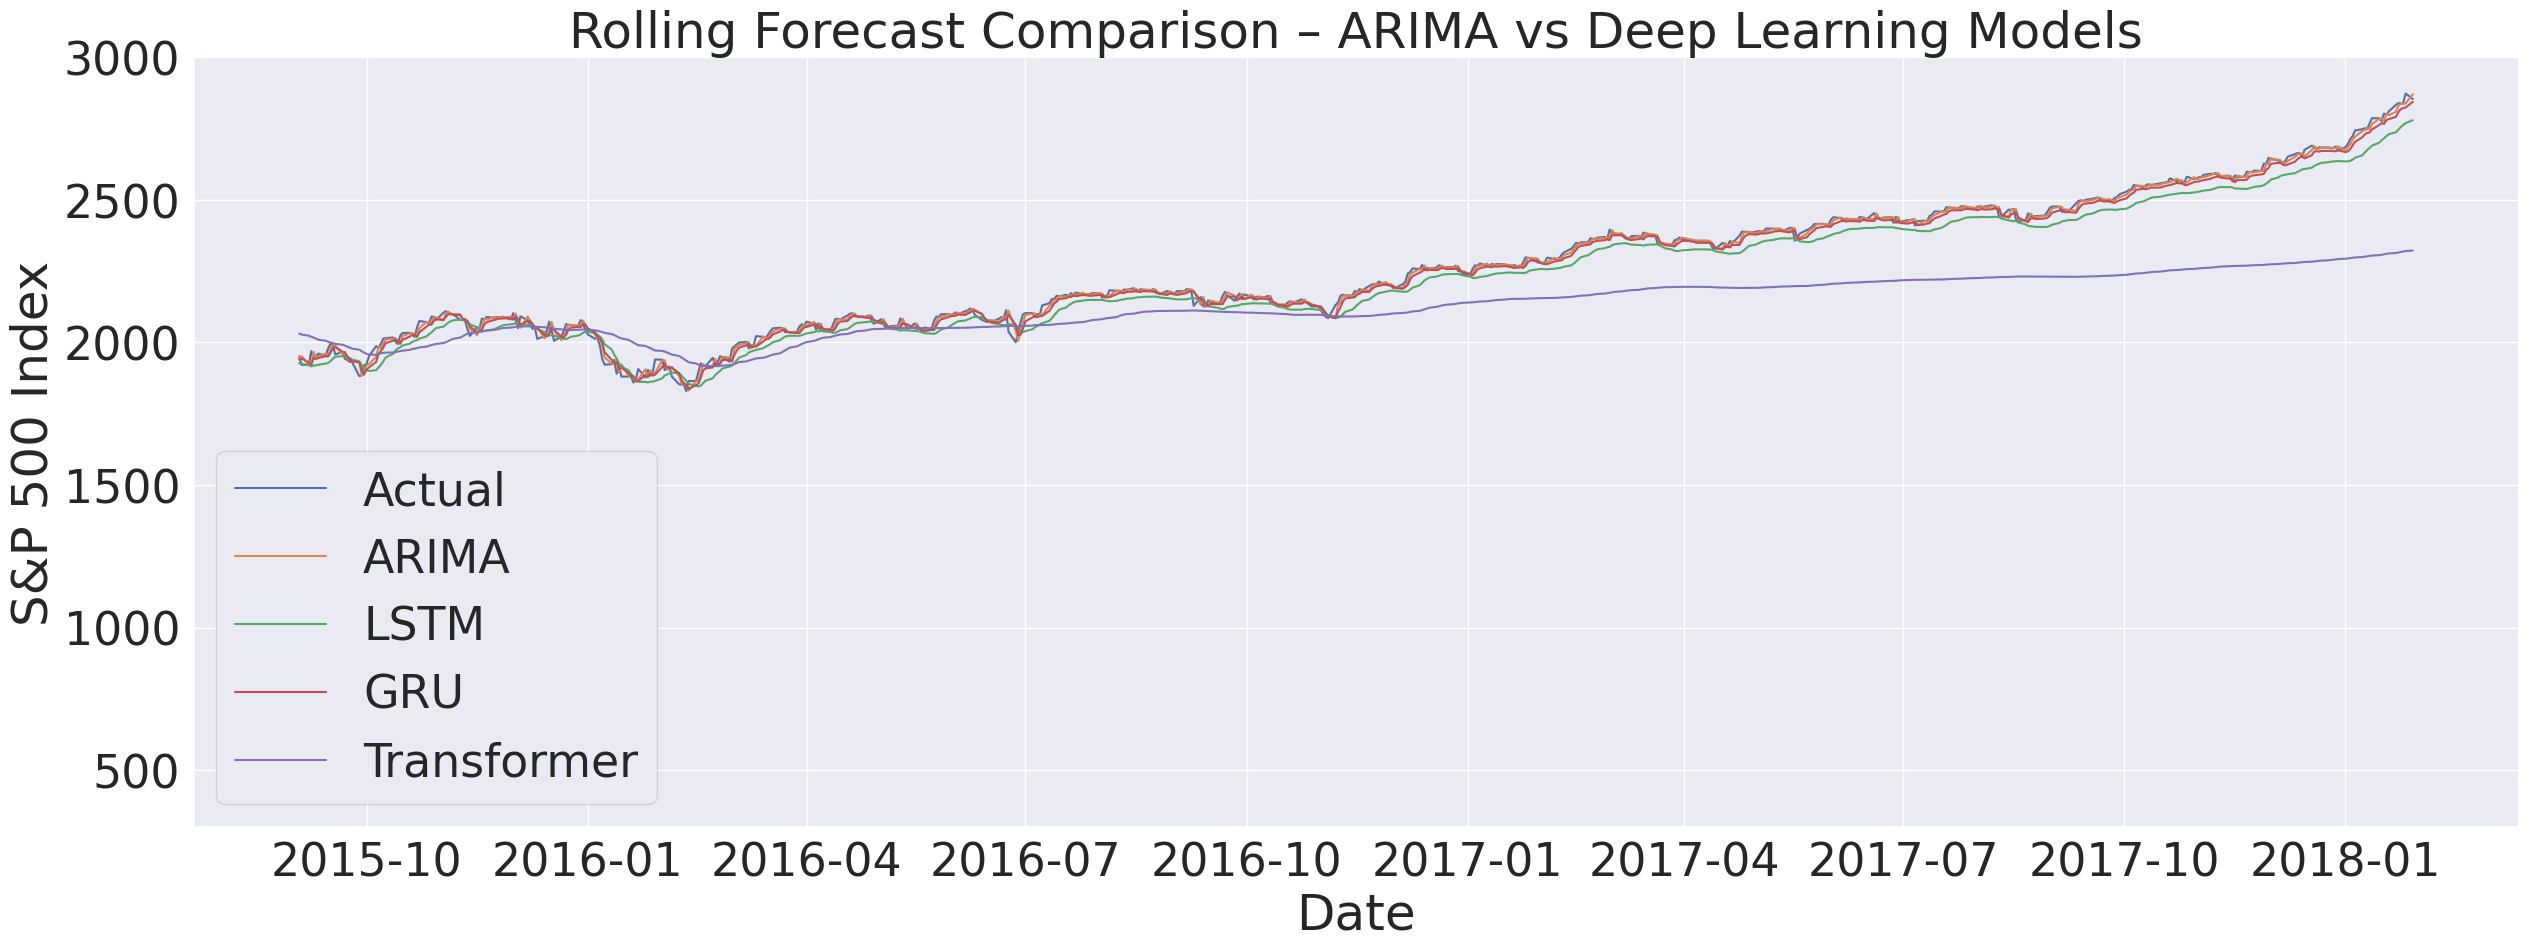

In [162]:
plt.figure(figsize=(30, 10))
plt.ylim(300, 3000)

sns.lineplot(data=combined_plot, x='date', y='Actual', label='Actual')
sns.lineplot(data=combined_plot, x='date', y='ARIMA_Rolling', label='ARIMA')
sns.lineplot(data=combined_plot, x='date', y='LSTM_Rolling', label='LSTM')
sns.lineplot(data=combined_plot, x='date', y='GRU_Rolling', label='GRU')
sns.lineplot(data=combined_plot, x='date', y='Transformer_Rolling', label='Transformer')

plt.xlabel("Date")
plt.ylabel("S&P 500 Index")
plt.title("Rolling Forecast Comparison – ARIMA vs Deep Learning Models")
plt.legend()
plt.grid(True)
plt.show()
